In [ ]:
# Importing the libraries
import os
import shutil
import tensorflow as tf
import numpy as np
import itertools
from IPython.display import Image
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from PIL import UnidentifiedImageError
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from concurrent.futures import ThreadPoolExecutor

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Define the paths
original_data = '/content/drive/MyDrive/Plantly'
train_data = os.path.join(original_data, 'train')
test_data = os.path.join(original_data, 'test')
validation_data = os.path.join(original_data, 'validation')

print("Paths defined successfully")

Paths defined successfully


In [ ]:
# Checking if path exists
print("Train Path Exists:", os.path.exists(train_data))
print("Test Path Exists:", os.path.exists(test_data))
print("Validation Path Exists:", os.path.exists(validation_data))


Train Path Exists: True
Test Path Exists: True
Validation Path Exists: True


In [ ]:
# Check the length
print("Train Length:", len(os.listdir(train_data)))
print("Test Length:", len(os.listdir(test_data)))
print("Validation Length:", len(os.listdir(validation_data)))

Train Length: 4
Test Length: 4
Validation Length: 4


In [ ]:
# Image parameters
Image_Size = 256
Batch_Size = 32
Shuffle_Size = 1000
Image_Shape = (Image_Size, Image_Size, 3)

In [ ]:
# Define a custom iterator for segmentation
class SegmentationIterator(Sequence):
  def __init__(self, x_set, y_set, data_gen, batch_size=Batch_Size, shuffle=True):
    self.x, self.y = x_set, y_set
    self.batch_size = batch_size
    self.data_gen = data_gen
    self.shuffle = shuffle
    self.indexes = np.arange(len(self.x))
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __len__(self):
    return len(self.x) // self.batch_size

  def __getitem__(self, idx):
    batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
    batch_x = [self.x[i] for i in batch_indexes]
    batch_y = [self.y[i] for i in batch_indexes]
    return self.__data_generation(batch_x, batch_y)

  def on_epoch_end(self):
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, batch_x, batch_y):
    batch_images, batch_masks = [], []

    for i in range(len(batch_x)):
        image, mask = batch_x[i], batch_y[i]

        try:
            image, mask = self.data_gen.apply_segmentation_augmentation(image, mask)
            batch_images.append(image)
            batch_masks.append(mask)

        except (UnidentifiedImageError, OSError) as e:
            print(f"Warning: Skipping image due to error: {e} - File: {image}")

    return np.array(batch_images), np.array(batch_masks)




In [ ]:
# Data Augumentation
class SegmentationDataGenerator(ImageDataGenerator):
  def __init__(self, segmentation_args=None, **kwargs):
    super().__init__(**kwargs)
    self.segmentation_args = segmentation_args

  def apply_segmentation_augmentation(self, image, mask):
    if self.segmentation_args.get('horizontal_flip', False):
      if np.random.random() < 0.5:
        image = np.fliplr(image)
        mask = np.fliplr(mask)


    if self.segmentation_args.get('rotation_range', 0) > 0:
      rotation_range  = self.segmentation_args.get('rotation_range')
      theta = np.random.uniform(-rotation_range, rotation_range)
      image = tf.keras.preprocessing.image.random_rotation(image,theta)
      mask = tf.keras.preprocessing.image.random_rotation(mask,theta)

    if self.segmentation_args.get('width_shift_range', 0) > 0 or self.segmentation_args('height_shift_range', 0) > 0:
      width_shift = self.segmentation_args.get('width_shift_range')
      height_shift = self.segmentation_args.get('height_shift_range')
      image = tf.keras.preprocessing.image.random_shift(image, width_shift, height_shift)
      mask = tf.keras.preprocessing.image.random_shift(mask, width_shift, height_shift)

    return image, mask

  def flow(self, x, y=None, batch_size=Batch_Size, shuffle=True):
    return SegmentationIterator(
        x, y, self, batch_size, shuffle=shuffle
    )


In [ ]:
# Define segmentation-specific augmentation arguments
segmentation_args = {
    'horizontal_flip': True,
    'rotation_range': 20,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1
}

# Create an instance of the SegmentationDataGenerator
data_gen = SegmentationDataGenerator(
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    preprocessing_function=preprocess_input,
    segmentation_args=segmentation_args
)

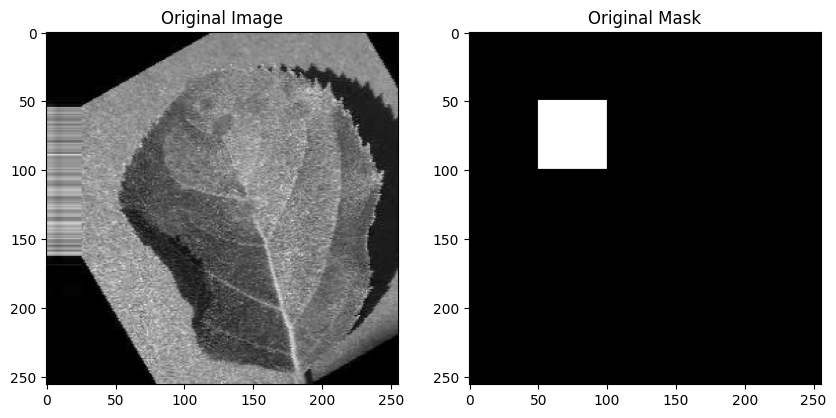

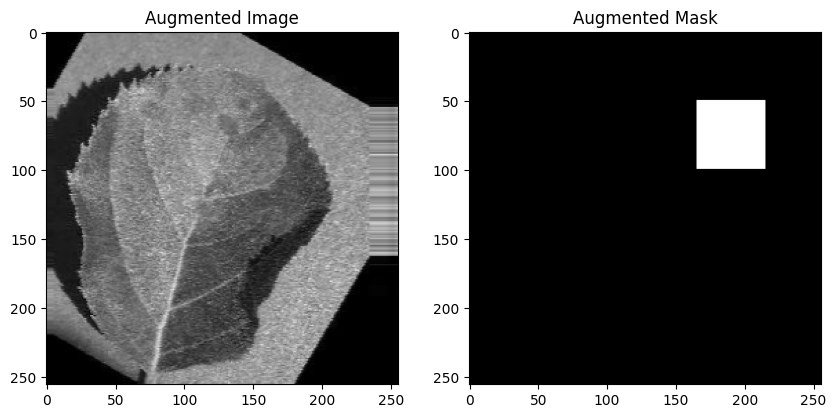

In [ ]:
# Load an display exaple image from the dataset
image_path = f"{train_data}/Apple_scab/0a769a71-052a-4f19-a4d8-b0f0cb75541c___FREC_Scab 3165_new30degFlipLR.JPG"
image = tf.keras.preprocessing.image.load_img(image_path)
image = tf.keras.preprocessing.image.img_to_array(image)
image, mask = data_gen.apply_segmentation_augmentation(image,image)

# Pseudo-mask
mask = np.zeros((image.shape[0], image.shape[1], 1), dtype=np.uint8)
mask[50:100, 50:100, 0] = 1

# Generate augumented samples
augumented_images, augumented_masks = data_gen.flow(
    np.expand_dims(image, axis=0),
    np.expand_dims(mask, axis=0),
    batch_size=1
).__getitem__(0)

# Display original image and mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.astype(np.uint8))
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(mask[:, :, 0], cmap='gray')
plt.title('Original Mask')
plt.show()

# Display augumented image and mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(augumented_images[0].astype(np.uint8))
plt.title('Augmented Image')
plt.subplot(1, 2, 2)
plt.imshow(augumented_masks[0][:, :, 0], cmap='gray')
plt.title('Augmented Mask')
plt.show()

In [ ]:
# Get the class names
train_names = sorted(os.listdir(train_data))
print(train_names)
test_names = sorted(os.listdir(train_data))
print(test_names)
validation_names = sorted(os.listdir(validation_data))
print(validation_names)

['Apple_Black_rot', 'Apple_Cedar_Rust', 'Apple_healthy', 'Apple_scab']
['Apple_Black_rot', 'Apple_Cedar_Rust', 'Apple_healthy', 'Apple_scab']
['Apple_Black_rot', 'Apple_Cedar_Rust', 'Apple_healthy', 'Apple_scab']


In [ ]:
# Generators
train_generator = data_gen.flow_from_directory(
    directory=train_data,
    target_size=(Image_Size,Image_Size),
    batch_size=Batch_Size,
    shuffle=True,
    class_mode='categorical'
)

test_generator = data_gen.flow_from_directory(
    directory=test_data,
    target_size=(Image_Size,Image_Size),
    batch_size=1,
    shuffle=False,
    class_mode='categorical'
)

validation_generator = data_gen.flow_from_directory(
    directory=validation_data,
    target_size=(Image_Size,Image_Size),
    batch_size=Batch_Size,
    shuffle=False,
    class_mode='categorical'
)

Found 7781 images belonging to 4 classes.
Found 23 images belonging to 4 classes.
Found 1943 images belonging to 4 classes.


In [ ]:
print(f"Number of batches: {len(test_generator)}")

Number of batches: 23


In [ ]:
# Define custom metrics
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_m = true_positives / (possible_positives + K.epsilon())
    return recall_m

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_m = true_positives / (predicted_positives + K.epsilon())
    return precision_m

def f1(y_true, y_pred):
    precision_m = precision(y_true, y_pred)
    recall_m = recall(y_true, y_pred)
    return 2 * ((precision_m * recall_m) / (precision_m + recall_m + K.epsilon()))


In [ ]:
# Load pre-trained ResNet50 model
resnet50 = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=Image_Shape)
resnet50.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Build the model on top of ResNet50
x = resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(4, activation="softmax")(x)
model = Model(inputs=resnet50.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0015),
              loss='categorical_crossentropy',
              metrics=['acc', f1, precision, recall])

In [ ]:
# Callbacks
checkpoint = ModelCheckpoint("resnet50_v1.keras",
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=False,
                             save_weights_only=False,
                             mode='auto',
                             save_freq='epoch')

early = EarlyStopping(monitor='val_acc',
                      min_delta=0,
                      patience=10,
                      verbose=1,
                      mode='auto')

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=5,
                              verbose=1,
                              min_lr=0.00001,
                              mode='auto')

In [ ]:
# Training the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[checkpoint, early, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - acc: 0.4362 - f1: 0.2439 - loss: 1.3785 - precision: 0.4491 - recall: 0.1853 
Epoch 1: saving model to resnet50_v1.keras
244/244 ━━━━━━━━━━━━━━━━━━━━ 3921s 16s/step - acc: 0.4365 - f1: 0.2445 - loss: 1.3774 - precision: 0.4497 - recall: 0.1858 - val_acc: 0.6264 - val_f1: 0.5890 - val_loss: 0.8309 - val_precision: 0.6554 - val_recall: 0.5381 - learning_rate: 0.0015
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - acc: 0.6101 - f1: 0.5800 - loss: 0.8696 - precision: 0.6644 - recall: 0.5182
Epoch 2: saving model to resnet50_v1.keras
244/244 ━━━━━━━━━━━━━━━━━━━━ 179s 732ms/step - acc: 0.6102 - f1: 0.5801 - loss: 0.8695 - precision: 0.6644 - recall: 0.5183 - val_acc: 0.6464 - val_f1: 0.6103 - val_loss: 0.8099 - val_precision: 0.7028 - val_recall: 0.5473 - learning_rate: 0.0015
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - acc: 0.6519 - f1: 0.6283 - loss: 0.7832 - precision: 0.6983 - recall: 0.5733
Epoch 3: saving model t

In [ ]:
# saving the model according to version
# Define the base path for saving models
base_path = "/content/drive/MyDrive/LeafGuardModel"

# Ensure the directory exists
os.makedirs(base_path, exist_ok=True)

# Get the next model version number
model_version = max(
    [int(i.split('V')[-1].split('.')[0]) for i in os.listdir(base_path)
     if 'V' in i and i.endswith(('.keras', '.h5'))] + [0]
) + 1

# Save the model with versioning
model_version_path = os.path.join(base_path, f"LeafGuardModelV{model_version}.keras")
model.save(model_version_path)

# Also save a fixed version (V1) if needed
fixed_version_path = os.path.join(base_path, "LeafGuardModelV1.h5")
model.save(fixed_version_path)

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
tflite_model_file = os.path.join(base_path, f"LeafGuardModelV{model_version}.tflite")
with open(tflite_model_file, 'wb') as f:
    f.write(tflite_model)

print(f'Model Saved Successfully:\n- Keras Model: {model_version_path}\n- Fixed Version: {fixed_version_path}\n- TFLite Model: {tflite_model_file}')

Saved artifact at '/tmp/tmpdjklom8_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  140237815318480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140237815318096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140237815317520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140237815318672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140237815318288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140237815319248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140237653004112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140237653005648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140237653006608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140237653004304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14023765300641

In [ ]:
# Visualizing the train and validation loss
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['acc'], label = 'training accuracy')
plt.grid(True)
plt.legend()

plt.plot(history.history['val_loss'], label = 'validation loss')
plt.plot(history.history['val_acc'], label = 'validation accuracy')
plt.grid(True)
plt.legend()

In [ ]:
# Showing how our model performed on the test image
for i in range(len(test_generator)):
    image_batch, label_batch = test_generator[i]  # Get batch

    if image_batch.shape[0] == 0:
        print(f"Skipping empty batch {i}")
        continue

    first_image = image_batch[0].astype('uint8')
    first_label = np.argmax(label_batch[0])

    plt.imshow(first_image)
    plt.axis('off')
    plt.show()

    print("Actual label:", train_names[first_label])

    batch_prediction = model.predict(image_batch)
    predicted_label = np.argmax(batch_prediction[0])

    print("Predicted label:", train_names[predicted_label])


In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy, test_f1, test_precision, test_recall = model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test F1 Score:", test_f1)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

In [ ]:
# Generate predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

print("Predicted Classes:", y_pred_classes)
print("True Classes:", y_true)

In [ ]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()


# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)


# Plot confusion matrix
class_labels = list(test_generator.class_indices.keys())
plt.figure(figsize=(10, 10))
plot_confusion_matrix(conf_matrix, classes=class_labels, title='Confusion Matrix')

In [ ]:
# Predict function
def get_prediction(image, model):
    # Ensure image is a NumPy array
    if isinstance(image, tf.Tensor):
        image = image.numpy()

    image = tf.keras.preprocessing.image.img_to_array(image)  # Convert image to array if needed
    image = tf.expand_dims(image, axis=0)  # Add batch dimension

    prediction = model.predict(image)
    predicted_class = train_names[np.argmax(prediction[0])]  # Get predicted class
    confidence = round(100 * np.max(prediction[0]), 2)  # Compute confidence score

    return predicted_class, confidence



In [ ]:
plt.figure(figsize=(12, 12))  # Set figure size

image_index = 0  # Track image index

for images, labels in test_generator:
    for i in range(len(images)):  # Loop through images in batch
        ax = plt.subplot(4, 5, image_index + 1)  # Adjust grid layout (change if needed)
        plt.imshow(images[i])  # Directly display image

        # Get predicted class and confidence
        predicted_class, confidence = get_prediction(images[i], model)

        # Get actual class
        actual_class = train_names[np.argmax(labels[i])]

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConf: {confidence}%", fontsize=8)
        plt.axis("off")

        image_index += 1  # Move to next image
        if image_index >= 20:  # Stop after 20 images
            break

    if image_index >= 20:
        break  # Stop after displaying all test images

plt.tight_layout()
plt.show()

In [ ]:
def save_model_for_serving(model, base_path, version=1):
    """
    Save model in TensorFlow SavedModel format for TF Serving
    """
    export_path = os.path.join(base_path, str(version))

    # Create directory if it doesn't exist
    os.makedirs(base_path, exist_ok=True)

    # Save model in SavedModel format
    tf.saved_model.save(model, export_path)

    # Convert and save TFLite model
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # Save TFLite model
    tflite_path = os.path.join(base_path, f'model_v{version}.tflite')
    with open(tflite_path, 'wb') as f:
        f.write(tflite_model)

    return export_path, tflite_path

In [ ]:
# Save the model for tf serving
serving_path = "/content/drive/MyDrive/LeafGuardModelV2/serving"

# Create the directory if it does not exist
os.makedirs(serving_path, exist_ok=True)

model_path, tflite_path = save_model_for_serving(model, serving_path)

print(f"SavedModel path: {model_path}")
print(f"TFLite model path: {tflite_path}")

Saved artifact at '/tmp/tmp4g48bdio'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  140237815318480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140237815318096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140237815317520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140237815318672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140237815318288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140237815319248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140237653004112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140237653005648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140237653006608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140237653004304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14023765300641